In [242]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""
# %pip install seaborn

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime as dt
from datetime import datetime

#Read the csv file
df = pd.read_csv('GOOG.csv')
print(df.head()) #7 columns, including the Date. 

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.813286  51.835709  47.800831  49.982655  49.982655  44871300
1  2004-08-20  50.316402  54.336334  50.062355  53.952770  53.952770  22942800
2  2004-08-23  55.168217  56.528118  54.321388  54.495735  54.495735  18342800
3  2004-08-24  55.412300  55.591629  51.591621  52.239193  52.239193  15319700
4  2004-08-25  52.284027  53.798351  51.746044  52.802086  52.802086   9232100


In [67]:
#Separate dates for future plotting
datelist_train = list(df['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d') for date in datelist_train]

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [40]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [279]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 2   # Number of days we want to look into the future based on the past days.
n_past = 2  # Number of past days we want to use to predict the future.

In [280]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4003, 2, 5).
trainY shape == (4003, 1).


In [281]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 2, 64)             13632     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________


In [282]:
# fit the model
history = model.fit(trainX, trainY, epochs=1, batch_size=16, validation_split=0.1, verbose=1)

226/226 [==============================] - 11s 38ms/step - loss: 0.0765 - val_loss: 0.0155


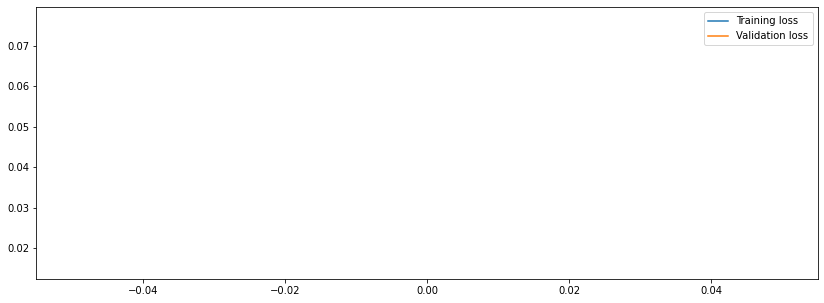

In [283]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [284]:
n_future_prediction = 2

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future_prediction, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.isoformat())


In [289]:
# Perform predictions
predictions_future = model.predict(trainX[-n_future_prediction:])
print(trainX.shape)
print(predictions_future.shape)

predictions_train = model.predict(trainX[n_past:])

1/1 [==============================] - 0s 25ms/step
(4003, 2, 5)
(2, 1)
126/126 [==============================] - 1s 6ms/step


In [291]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d')

prediction_copies_train = np.repeat(predictions_train, df_for_training.shape[1], axis=-1)
prediction_copies_future = np.repeat(predictions_future, df_for_training.shape[1], axis=-1)

y_pred_future = scaler.inverse_transform(prediction_copies_future)[:,0]
y_pred_train = scaler.inverse_transform(prediction_copies_train)[:,0]

forecast_dates = []
for time_i in datelist_future:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

PREDICTIONS_FUTURE = pd.DataFrame(df_forecast, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -3:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

print(prediction_copies_future)
print(PREDICTION_TRAIN.tail(3))
PREDICTIONS_FUTURE.tail(3)

[[2.7505493 2.7505493 2.7505493 2.7505493 2.7505493]
 [2.728825  2.728825  2.728825  2.728825  2.728825 ]]
                   Open
2020-07-15  1546.246460
2020-07-16  1535.460571
2020-07-17  1527.437012


,Open
2020-07-17,1535.460571
2020-07-18,1527.437012


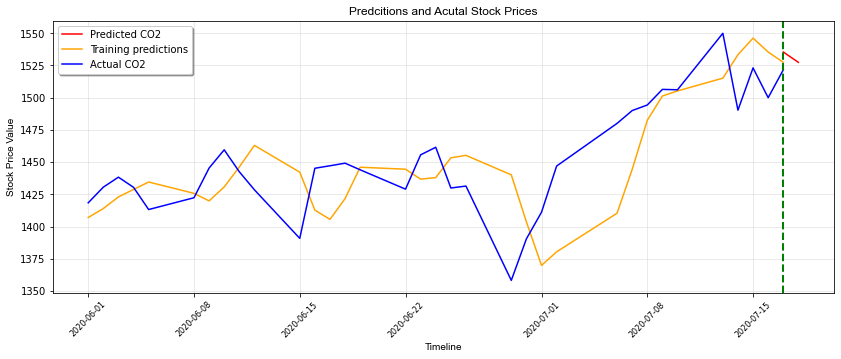

In [292]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted CO2')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual CO2')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [277]:
# Parse training set timestamp for better visualization
df = pd.DataFrame(df, columns=cols)
df.index = datelist_train
df.index = pd.to_datetime(df.index)